In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from keras.callbacks import EarlyStopping
import re

In [4]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    
    text = re.sub(pattern, '', x)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]**{4}**', '####', x)
        x = re.sub('[0-9]**{3}**', '###', x)
        x = re.sub('[0-9]**{2}**', '##', x)
    return x

In [5]:
df_old.drop_duplicates(inplace = True)

In [30]:
cleaned_text = []
for i in df_old["text"]:
    i = str(i)
    cleaned_text.append(i)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_old['text'],df_old['label'], test_size = 0.2,random_state = 43)

In [33]:
from sklearn import preprocessing
def prepare_targets(y_train, y_test):
    le = preprocessing.LabelEncoder()

    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [34]:
y_train,y_test = prepare_targets(y_train, y_test)
y_train_enc = tf.one_hot(y_train, 6) 
y_test_enc = tf.one_hot(y_test, 6)


In [46]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [47]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    #preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
    encoder_inputs = bert_preprocess(text_input)
    #encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
    outputs = bert_encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(6, activation="Softmax", name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [48]:
loss = "categorical_crossentropy"
metrics = "accuracy"

In [49]:
classifier_model = build_classifier_model()

In [50]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [51]:
epochs = 5
optimizer = "adam"
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

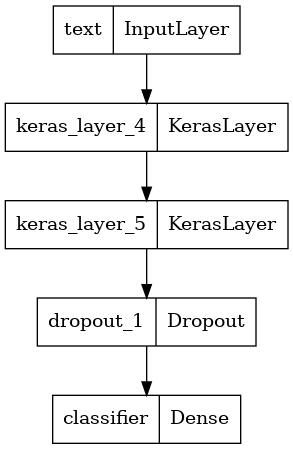

In [52]:
tf.keras.utils.plot_model(classifier_model)

In [53]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [54]:
callbacks = [EarlyStopping(monitor="val_loss",patience=5,verbose=0,mode="auto",restore_best_weights=True)]

In [55]:
history_bert = classifier_model.fit(X_train, y_train_enc,validation_data = (X_test,y_test_enc),epochs=epochs,callbacks = callbacks)

Epoch 1/5
592/592 [==============================] - 179s 287ms/step - loss: 1.5781 - accuracy: 0.3518 - val_loss: 1.4812 - val_accuracy: 0.3919
Epoch 2/5
592/592 [==============================] - 168s 285ms/step - loss: 1.4728 - accuracy: 0.3995 - val_loss: 1.4173 - val_accuracy: 0.4293
Epoch 3/5
592/592 [==============================] - 169s 285ms/step - loss: 1.4231 - accuracy: 0.4243 - val_loss: 1.3677 - val_accuracy: 0.4439
Epoch 4/5
592/592 [==============================] - 169s 286ms/step - loss: 1.3943 - accuracy: 0.4359 - val_loss: 1.3481 - val_accuracy: 0.4502
Epoch 5/5
592/592 [==============================] - 169s 285ms/step - loss: 1.3796 - accuracy: 0.4437 - val_loss: 1.3292 - val_accuracy: 0.4551
